In [1]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
movies = pd.read_csv('3b movies_GloVe.csv')
country_codes = pd.read_csv('country_codes.csv')

In [3]:
def get_numbers(str):
    """Return the integer numbers from a string in an array format."""
    arr = str.replace(',','').replace('{','').replace('}','').replace('[','').replace(']','').split()
    arr = [int(s) for s in arr if s.isdigit()]
    return arr

def get_country_codes(str):
    """Return the codes of the countries from a string."""
    arr = str.replace(',','').replace('{','').replace('}','').replace('[','').replace(']','').replace("'", "").split()
    arr = [s for s in arr if country_codes['Code'].str.contains(s).any()]
    return arr

def prepare_dataframe(movies):
    
    movies = movies.drop(['id', 'title'], axis=1)
    
    # Categorical values are not used, because of the algorithm
    numeric = movies.drop(['adult', 'genres', 'original_language', 'production_companies', 'production_countries'], axis=1)
    
    # Scale the numeric values to (0, 1) interval
    scaler = MinMaxScaler()
    numeric = scaler.fit_transform(numeric)
    
    movievectors = pd.DataFrame(numeric)
    
    return movievectors

In [4]:
movies = prepare_dataframe(movies)

In [14]:
# 1. test: PCA vs random dimension cut, with 5 clusters
df1 = pd.DataFrame(columns=['Number of dimensions','Silhouette score with PCA', 'Silhouette score with random cut'])
clusters = 5
for dimensions in range(movies.shape[1], 2, -2):
    
    # PCA
    pca = PCA(n_components=dimensions)
    reduced_data_PCA = pca.fit_transform(movies)
    
    kmeans_PCA = KMeans(n_clusters=clusters)
    kmeans_PCA.fit(reduced_data_PCA)
    
    silscore_PCA = silhouette_score(reduced_data_PCA, kmeans_PCA.predict(reduced_data_PCA))
    
    # Random dimension cut
    reduced_data_rand = movies.sample(n=dimensions, axis='columns')
    
    kmeans_rand = KMeans(n_clusters=clusters)
    kmeans_rand.fit(reduced_data_rand)  
    
    silscore_rand = silhouette_score(reduced_data_rand, kmeans_rand.predict(reduced_data_rand))
    
    scores = pd.DataFrame([[dimensions, silscore_PCA, silscore_rand]],
                          columns=['Number of dimensions','Silhouette score with PCA', 'Silhouette score with random cut'])
    df1 = pd.concat([df1, scores], axis=0)

In [15]:
df1 = df1.reset_index().drop('index', axis=1)

<AxesSubplot:xlabel='Number of dimensions', ylabel='Silhouette Score'>

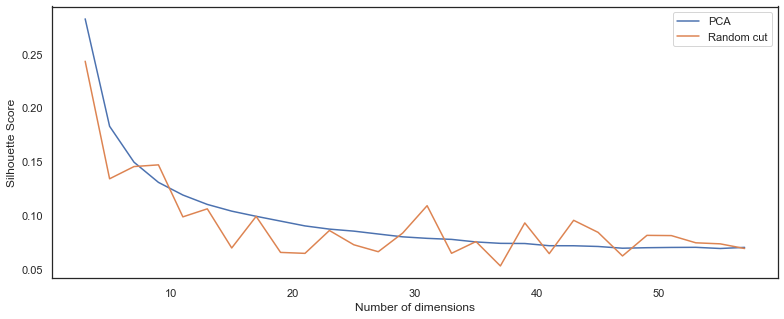

In [17]:
# Visualize the results
sns.set_theme(style="white")
plt.figure(figsize=(13,5))
plt.ylabel('Silhouette Score')

sns.lineplot(data = df1, x='Number of dimensions', y='Silhouette score with PCA', label='PCA')
sns.lineplot(data = df1, x='Number of dimensions', y='Silhouette score with random cut', label='Random cut')

In [19]:
df1

,Number of dimensions,Silhouette score with PCA,Silhouette score with random cut
0,57,0.070182,0.069126
1,55,0.069151,0.073475
2,53,0.070242,0.074440
3,51,0.070136,0.081151
4,49,0.069879,0.081364
5,47,0.069413,0.062213
6,45,0.071025,0.084154
7,43,0.071696,0.095365
8,41,0.071733,0.064369
9,39,0.073780,0.092929


In [5]:
# 2. test: Measure matching of original clustering and clustering after PCA
clusters = 5
dimensions = 3

kmeans_all = KMeans(n_clusters=clusters, random_state=98)
kmeans_all.fit(movies)

pca = PCA(n_components=dimensions)
reduced_data_PCA = pca.fit_transform(movies)
    
kmeans_PCA = KMeans(n_clusters=clusters, random_state=98)
kmeans_PCA.fit(reduced_data_PCA)

KMeans(n_clusters=5, random_state=98)

In [6]:
all_data_clusters = kmeans_all.predict(movies)
after_pca_clusters = kmeans_PCA.predict(reduced_data_PCA)

In [7]:
sum(all_data_clusters == after_pca_clusters)

18877

In [8]:
# As percentage of all movies
sum(all_data_clusters == after_pca_clusters) / movies.shape[0]

0.42523427644620654